In [1]:
# Import necessary libraries

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import urllib
import numpy as np
import json
import gensim
import gensim.downloader
import re 

# Download word vectorizer
vectors = gensim.downloader.load('glove-wiki-gigaword-50')


# Download data
def get_response(url):
    operUrl = urllib.request.urlopen(url)
    if(operUrl.getcode()==200):
        data = operUrl.read()
    else:
        print("Error receiving data", operUrl.getcode())
    return data

data = get_response('https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json')


# Load and combine data into train, val, and test sets
json_data = json.loads(data)
val = json_data['val']
oos_val = json_data['oos_val']
test = json_data['test']
oos_test = json_data['oos_test']
train = json_data['train']
oos_train = json_data['oos_train']


for i in oos_train:
    train.append(i) 

for i in oos_val:
    val.append(i) 

for i in oos_test:
    test.append(i) 

### Strip data of symbols and convert to lists of strings    
# Create regex pattern
pattern = re.compile('[^\w\s]')

# Define function to apply regex pattern over each dataset
def string_separation(data):
    return [pattern.sub('', data[i][0]).split(" ") \
     for i, j in enumerate(data)]

# Apply function to each dataset
train_separated_values = string_separation(train)
val_separated_values = string_separation(val)
test_separated_values = string_separation(test)


### vectorize each value using word2vec

# Create function that checks if a string can be vectorized against the vectorizer
# If it can, vectorize it, otherwise return a 0.0 array of equal size
def get_vector(string):
    try: 
        value = vectors.get_vector(string)
        return value
    except:
        return np.array([0.0] * 50)
    
# Create a function that applies the get_vector function across a list of values
def convert_to_vectors(series):
    new_series = []

    for i in series:
        if i == '':
            pass
        else:
            new_series.append(get_vector(i))
            
    return new_series

In [2]:
# Define a function that applies convert_to_vectors across an entire dataset
def vectorize_samples(data):
    return [convert_to_vectors(data[i]) for i, j in enumerate(data)]

In [3]:
# Vectorize each dataset
train_X_arrays = vectorize_samples(train_separated_values)
val_X_arrays = vectorize_samples(val_separated_values)
test_X_arrays = vectorize_samples(test_separated_values)

In [4]:
# Since values are being assigned to Tensors establish the storage location by checking for GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Establish padding length (Could have been as low as 30 given data set 50 was chosen to increase usability)
pad_length = 50

# Create an empty array to be used for padding values
pad_value = np.array([0.0] * 50, dtype=np.float32)

# Define function that takes a list, pad_length, and pad_value to create a new array of values with 0 padded values up to the pad_length
def adjust_padding(some_list, pad_length=pad_length, pad_value=pad_value):
    some_list = list(some_list)
    while len(some_list) < pad_length:
        some_list.append(pad_value)
    return np.array(some_list)

# Apply the function over each dataset
train_padded      = [adjust_padding(i) for i in train_X_arrays]
val_padded        = [adjust_padding(val_X_arrays[i]) for i, j in enumerate(val_X_arrays)]
test_padded       = [adjust_padding(test_X_arrays[i]) for i, j in enumerate(test_X_arrays)]

# Convert arrays to tensors to feed model

train_set         = torch.tensor(train_padded).reshape((15100,1,50,50)).float().to(device)
val_set           = torch.tensor(val_padded).reshape((3100,1,50,50)).float().to(device)
test_set          = torch.tensor(test_padded).reshape((5500,1,50,50)).float().to(device)

# Create tensors of answers

train_answer      = [j[1] for i, j in enumerate(train)]
val_answer        = [j[1] for i, j in enumerate(val)]
test_answer       = [j[1] for i, j in enumerate(test)]

### Create an index to train against

# Create dictionary map of each unique answer type
chosen_dict = {j: i for i, j in enumerate(list(set([train[i][1] for i, j in enumerate(train)])))}

# Use dictionary to consistently label answer data
for item in chosen_dict.keys():
    for i, j in enumerate(train_answer):
        if item == j:
            train_answer[i] = chosen_dict[item]
    for i, j in enumerate(val_answer):
        if item == j:
            val_answer[i] = chosen_dict[item]
    for i, j in enumerate(test_answer):
        if item == j:
            test_answer[i] = chosen_dict[item]

# Convert labeled data into tensors
train_answers = torch.tensor(train_answer).to(device)
val_answers = torch.tensor(val_answer).to(device)
test_answers = torch.tensor(test_answer).to(device)

In [5]:
### Build model in PyTorch

class ClassifierModel(nn.Module):

    def __init__(self):

        super(ClassifierModel, self).__init__()
        
        self.wide_conv = nn.Conv2d(1, 32, (5, 50))
        self.narrow_conv1 = nn.Conv2d(1, 32, (3, 50))
        self.narrow_conv2 = nn.Conv1d(32, 32, (3))
        self.conv2 = nn.Conv1d(64, 128, (3))
        self.linear1 = nn.Linear(128*44, 256)
        self.linear2 = nn.Linear(256, 128)
        self.probs_pre = nn.Linear(128, 151) # 151 output classes
        self.probabilities = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(.25)

    def forward(self, x):
        # Use wide (5) word convolution to capture longer-term dependencies
        y = F.elu(self.wide_conv(x))
        y = y.view(y.shape[0:3])
        # Use short (3) word convolution to capture neighboring relationships
        z = F.elu(self.narrow_conv1(x))
        z = z.view(z.shape[0:3])
        z = F.elu(self.narrow_conv2(z))
        # Concatenate results
        x = torch.cat((y, z), 1)
        # Perform one additional convolution to evaluate the connection between dependencies
        x = F.elu(self.conv2(x))
        # Pass to Feed Forward ANN to produce probabilities of each class
        # Use dropout to reduce overfitting and assist model with training on un-seen data
        x = x.view(-1, 128*44)
        x = F.elu(self.dropout(self.linear1(x)))
        x = F.elu(self.dropout(self.linear2(x)))
        x = self.probabilities(self.probs_pre(x))
        
        return x

In [6]:
# Instantiate model, optimizer, and loss criteria and begin first iteration of training.

model = ClassifierModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)


loss_list = []
val_loss_list = []



for epoch in range(50000):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(train_set)
    loss = criterion(outputs, train_answers)
    
    loss_list.append(float(str(loss).split("(")[1].split(",")[0]))
    
    loss.backward()
    optimizer.step()
    
    val_outputs = model(val_set)
    val_loss = criterion(val_outputs, val_answers)
    
    val_loss_list.append(float(str(val_loss).split("(")[1].split(",")[0]))
    
    # print statistics
    if epoch % 500 == 0:
        print("Loss:     " + str(loss).split("(")[1].split(",")[0])
        print("Val Loss: " + str(val_loss).split("(")[1].split(",")[0])
        print(str(epoch/500) + "% done")

print('Finished Training')

# Save initial training results

torch.save(model, '.\\models\\proper_vectors.1_save')

Loss:     5.0173
Val Loss: 5.0172
0.0% done
Loss:     4.5673
Val Loss: 4.6670
1.0% done
Loss:     4.4738
Val Loss: 4.6038
2.0% done
Loss:     4.4552
Val Loss: 4.5827
3.0% done
Loss:     4.4413
Val Loss: 4.5674
4.0% done
Loss:     4.4224
Val Loss: 4.5588
5.0% done
Loss:     4.3956
Val Loss: 4.5482
6.0% done
Loss:     4.3794
Val Loss: 4.5325
7.0% done
Loss:     4.3730
Val Loss: 4.5303
8.0% done
Loss:     4.3591
Val Loss: 4.5154
9.0% done
Loss:     4.3326
Val Loss: 4.5006
10.0% done
Loss:     4.3057
Val Loss: 4.4729
11.0% done
Loss:     4.2726
Val Loss: 4.4515
12.0% done
Loss:     4.2718
Val Loss: 4.4496
13.0% done
Loss:     4.2653
Val Loss: 4.4416
14.0% done
Loss:     4.2585
Val Loss: 4.4434
15.0% done
Loss:     4.2333
Val Loss: 4.4328
16.0% done
Loss:     4.2127
Val Loss: 4.4127
17.0% done
Loss:     4.2056
Val Loss: 4.4100
18.0% done
Loss:     4.1986
Val Loss: 4.4002
19.0% done
Loss:     4.1858
Val Loss: 4.3982
20.0% done
Loss:     4.1857
Val Loss: 4.3970
21.0% done
Loss:     4.1736
Val

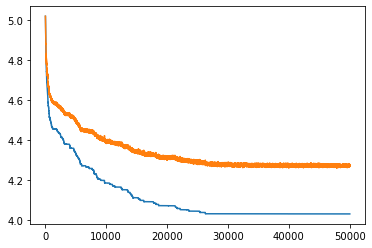

In [7]:
# Check if additional training is likely to yield improvements

plt.plot(loss_list)
plt.plot(val_loss_list)

In [9]:
# Test model on validation set for estimated performance
outputs = model(val_set)

maxes = np.argmax(outputs.to('cpu').detach().numpy(), axis = 1)
correct_guesses = [maxes[i] == val_answer[i] for i in range(len(maxes))]

print("Percent correct (Accuracy): " + str(correct_guesses.count(True)/len(correct_guesses)))

Percent correct (Accuracy): 0.7651612903225806
